<h1>Deskripsi</h1>
<h2>Terdapat 3 Jenis Data Kanker Payudara</h2>
  <ol>
    <li>Jinak</li>
    <li>Ganas</li>
    <li>Normal</li>
  </ol>

# **1.** **INSTALL** **LIBRARY**

In [1]:
!pip install tensorflow numpy matplotlib opencv-python pandas kagglehub keras

# **2.** **IMPORT LIBRARY**

In [2]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *

#aniani
import os
import kagglehub

# **3.** **Ambil** **Dataset**

In [3]:
breast_ultrasound_images_dataset_path = kagglehub.dataset_download('aryashah2k/breast-ultrasound-images-dataset')
print(breast_ultrasound_images_dataset_path)

100%|██████████| 195M/195M [00:09<00:00, 21.1MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1


# **4.** **Pindah Dataset Didirector Awal**
1. Jalankan Script Dibawah
2. PINDAHKAN SECARA MANUAL Foler "Dataset_BUSI_with_GT" Diluar alias di /content/(**DISINI**)

In [28]:
!mv /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1 /content/

# **5.** **Pindah Dataset Di Director Awal**

In [7]:
path_Dataset = glob("/content/Dataset_BUSI_with_GT/*")

for i in path_Dataset:
  print(f"Director : {i} \t| TOTAL IMAGE FOLDER : {len(os.listdir(i))}")

# **5. Fungsi Untuk LOAD DATASET**

In [11]:
def load_image(path, size):
  image = cv2.imread(path)
  image = cv2.resize(image, (size,size))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
  image = image/255.   # normalize
  return image

def load_data(root_path, size):
  images = []
  masks = []

  x = 0   # variabel tambahan untuk mengidentifikasi gambar yang terdiri dari 2 atau lebih topeng

  for path in sorted(glob(root_path)):
    img = load_image(path, size)   # Membaca Mask dan Gambar

    if 'mask' in path:
      if x:   # Gambar yang Memiliki Mask lebih dari 1
        masks[-1] += img # Tambahkan Gambar Mask ke terakhir mask

        # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
        masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
      else:
        masks.append(img)
        x = 1   # if the image has a mask again, the above code will run next time

    else:
      images.append(img)
      x = 0   # for moving to the next image

  return np.array(images), np.array(masks), x # Return x as well

size = 128   # image size: 128x128
X, y,x= load_data(root_path = 'Dataset_BUSI_with_GT/*/*', size=128) # Assign returned x to a variable in global scope

# print(f"Variabel X : {X}\nVariabe : {x}\nVariabel : {y}")
print(f"Variabel X : {type(X)}\nVariabe : {type(x)}\nVariabel : {type(y)}")

Variabel X : <class 'numpy.ndarray'>
Variabe : <class 'int'>
Variabel : <class 'numpy.ndarray'>


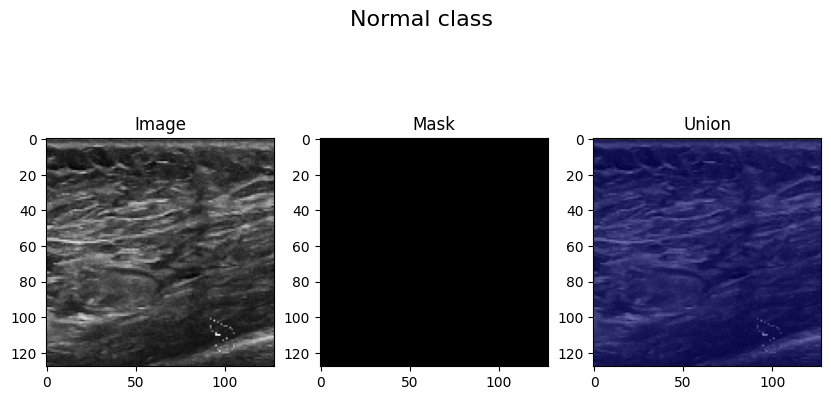

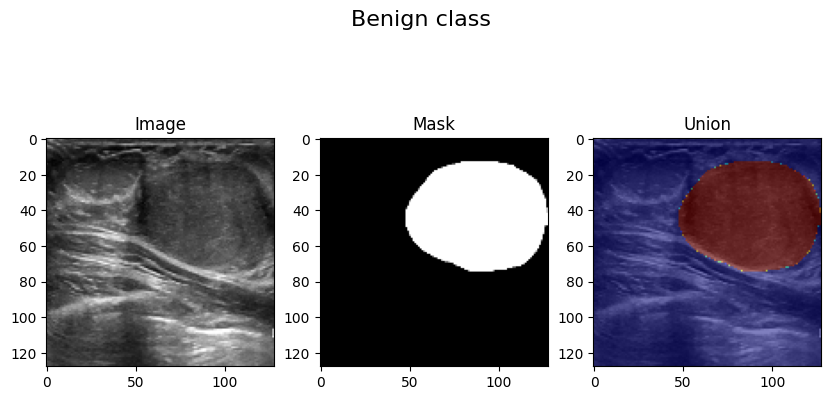

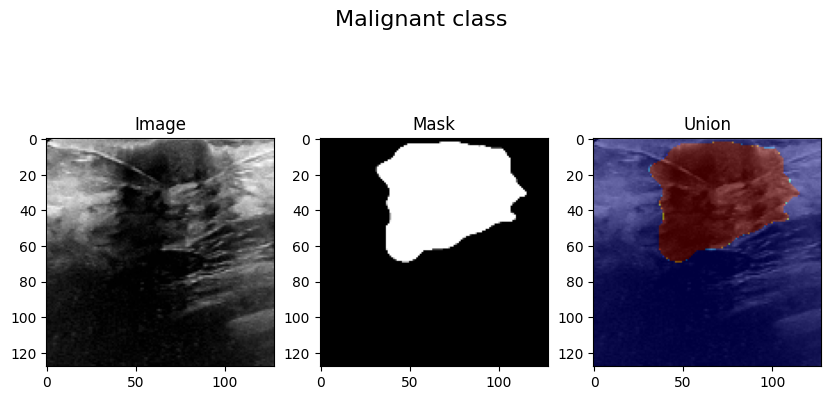

In [13]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal

# Menampilkan Dataset Image dari Payudara Normal (Normal)
i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()


# Menampilkan Dataset Image dari Kanker Payudara Unio (Jinak)
fig, ax = plt.subplots(1,3, figsize=(10,5))
i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()


# Menampilkan Dataset Image dari Kanker Payudara Malignant (Ganas)
fig, ax = plt.subplots(1,3, figsize=(10,5))
i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

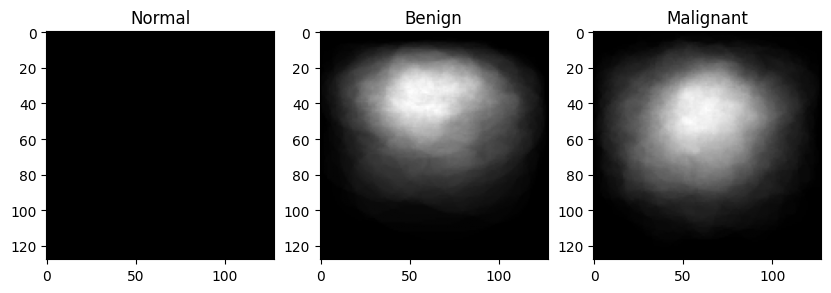

In [90]:
# Menampilkan Gambar setiap 3 jenis (normal,Jinak,Ganas)
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()



# **6. Preprosesing Dataset**

In [14]:
# Menghapus kelas normal karna kelas normal tidak memiliki Mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# menyiapkan data untuk pemodelan
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


# **7. Train Split Dataset**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


# **8. Membangun Arsitektur Dengan pecahan Fungsi U-Net**


1. Conv block
2. Encoder block
3. Decoder block
4. Build model
5. Model plotting
6. Melihat Semua Layer yang dibuat (summary)
7. Train Dataset (BUILD MODEL)
8. Melihat TOTAL Training Model (Lost dan Akurat) dengan Matplotib


In [16]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

In [17]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [19]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

In [20]:
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary(show_trainable=True)

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 128, 128, 1)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 128, 128, 64) │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 128, 128, 64) │       36,928 │ conv2d[0][0]        │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 64, 64, 64)   │            0 │ conv2d_1[0][0]      │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 64, 128)  │       73,856 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 64, 64, 128)  │      147,584 │ conv2d_2[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_1        │ (None, 32, 32, 128)  │            0 │ conv2d_3[0][0]      │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_4 (Conv2D)      │ (None, 32, 32, 256)  │      295,168 │ max_pooling2d_1[0]… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)      │ (None, 32, 32, 256)  │      590,080 │ conv2d_4[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_2        │ (None, 16, 16, 256)  │            0 │ conv2d_5[0][0]      │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_6 (Conv2D)      │ (None, 16, 16, 512)  │    1,180,160 │ max_pooling2d_2[0]… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_7 (Conv2D)      │ (None, 16, 16, 512)  │    2,359,808 │ conv2d_6[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_3        │ (None, 8, 8, 512)    │            0 │ conv2d_7[0][0]      │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_8 (Conv2D)      │ (None, 8, 8, 1024)   │    4,719,616 │ max_pooling2d_3[0]… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_9 (Conv2D)      │ (None, 8, 8, 1024)   │    9,438,208 │ conv2d_8[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_transpose       │ (None, 16, 16, 512)  │    2,097,664 │ conv2d_9[0][0]      │    Y    │
│ (Conv2DTranspose)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate          

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8665 - loss: 0.7808 - val_accuracy: 0.9257 - val_loss: 0.3068
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 423ms/step - accuracy: 0.8999 - loss: 0.3420 - val_accuracy: 0.9257 - val_loss: 0.2172
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.8869 - loss: 0.3321 - val_accuracy: 0.9257 - val_loss: 0.3484
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.9046 - loss: 0.3190 - val_accuracy: 0.9257 - val_loss: 0.2182
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - accuracy: 0.8998 - loss: 0.2650 - val_accuracy: 0.9263 - val_loss: 0.1931
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.9089 - loss: 0.2249 - val_accuracy: 0.9339 - val_loss: 0.1732
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step - accuracy: 0.8917 - loss: 0.2846 - val_accuracy: 0.9257 - val_loss: 0.2065
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.9011 - loss: 0.2371 - val_a

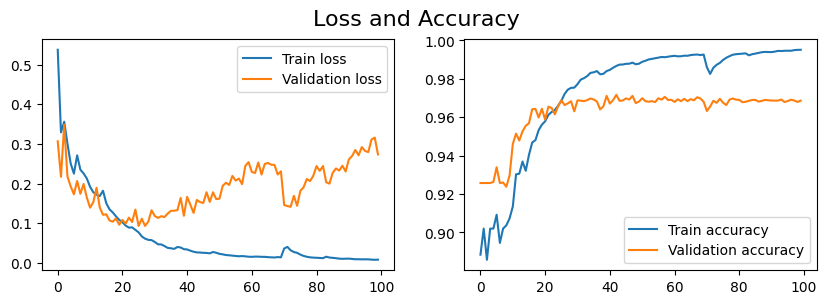

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

#Result

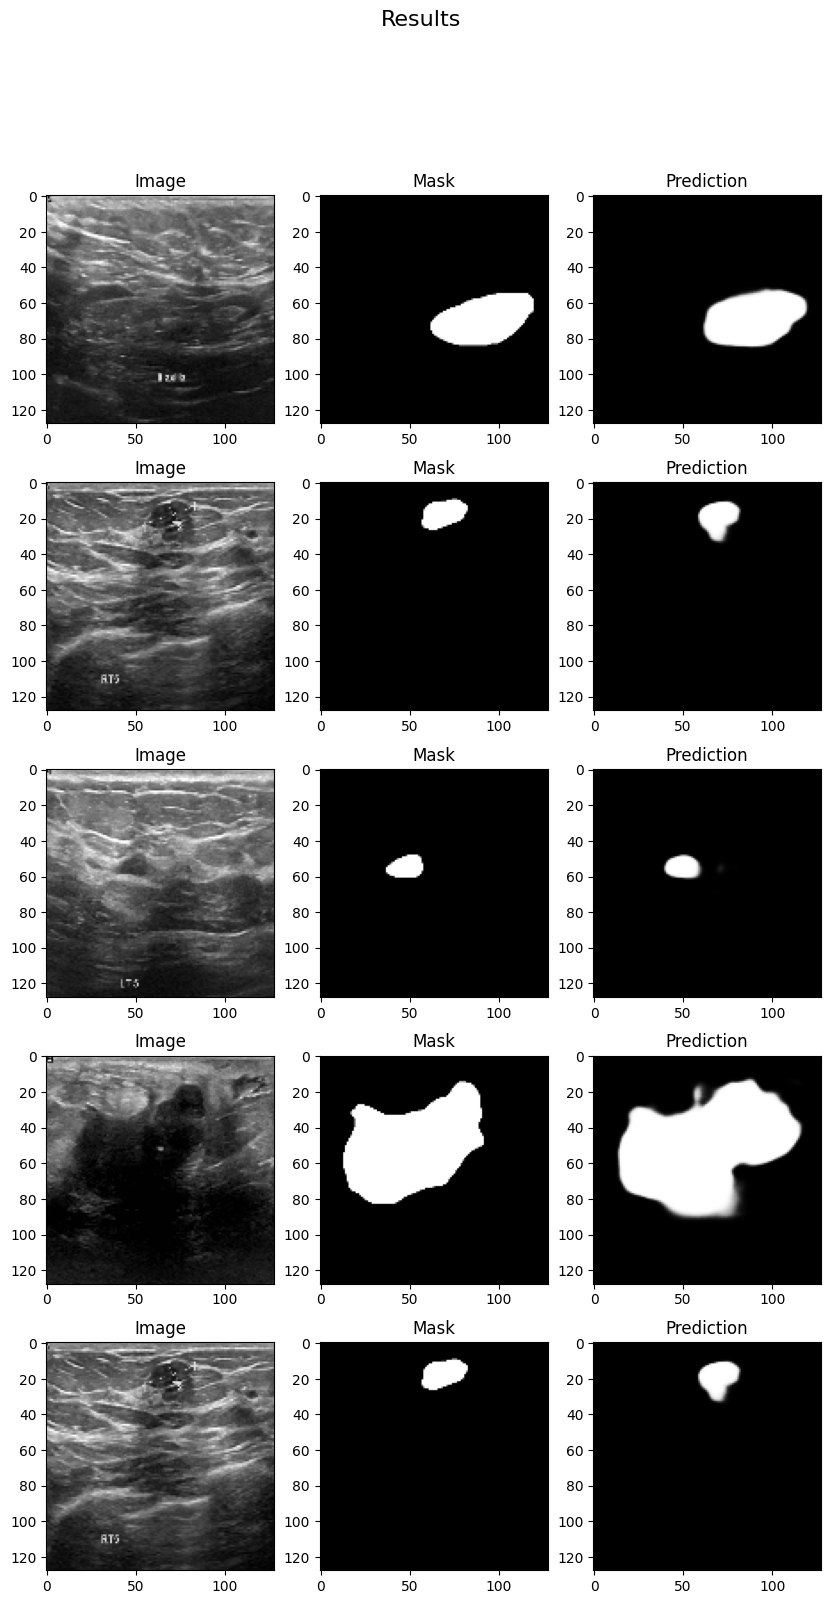

In [23]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

#Menampilkan Hasil dari :
  1. Mean IoU
  2. Precision Score
  3. Recall Score
  4. F1 Score


In [25]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.80928046
Precision Score = 0.773
Recall Score = 0.805
F1 Score = 0.789


#SAVE MODEL HASIL LEARNING

In [24]:
model.save('model_Deteksi_Kanker_Payudara_unet.h5')